In [48]:
# determine the current project folder
import pathlib

# determine the current project folder
project_folder = pathlib.Path().parent.absolute()
project_folder
# Seeds
# set specific seeds to get the exact same results across different experiments
import numpy as np
import random

np.random.seed(44)
random.seed(44)
# User Input Parameters
INPUT_FILE_NAME = "GDS1962.csv"
GROUP_FILE_NAME = "cancer-DisGeNET.txt"
GROUP_COLUMN_NAME = "diseaseName"

NUMBER_OF_ITERATION = 5
MODEL_NAME = "RandomForest" # DecisionTree, RandomForest, SVM, KNN, MLP
LABEL_OF_POSITIVE_CLASS = "pos"
LABEL_OF_NEGATIVE_CLASS = "neg"
CLASS_MIN_BALANCE_RATIO = 0.5 # this is to handle imbalanced data by undersampling the majority class 
# (e.g. if the ratio is 0.5, the majority class has 1000 samples, and the minority class has 200 samples, then the majority class will be undersampled to 400 samples)
TRAIN_TEST_RATIO = 0.7

NORMALIZATION = "minmax" # minmax, zscore
FILTER_FEATURES_BY_TTEST_TO = 1000 # 0 to disable
FILTER_BEST_X_GROUPS = 10
# Input
# read the csv input from data folder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read the csv input from data folder
data_folder = project_folder / "data"
data_file = data_folder / INPUT_FILE_NAME
data = pd.read_csv(data_file)
# print the first 5 rows of the data
data.head()

,class,MIR4640,RFC2,HSPA6,PAX8,GUCA1A,MIR5193,THRA,PTPN21,CCL5,...,LRCH4(2),LRTM1(1),MIR1306(3),91682_at,EXOSC4(2),EHBP1L1(3),MEX3D(2),EPS8L1(4),BCAN(3),DCAF15(3)
0,neg,4701.5,282.7,769.6,1616.3,232.7,357.7,245.1,33.2,30.7,...,453.4,30.8,585.5,724.2,476.0,215.8,1002.0,71.7,1524.7,318.9
1,neg,4735.0,347.9,287.9,1527.2,204.8,336.5,186.2,22.9,57.1,...,439.9,34.1,453.2,603.1,347.1,269.6,1017.2,33.0,1742.0,304.5
2,neg,2863.9,355.0,199.0,1793.8,119.3,328.7,349.3,30.0,17.8,...,200.0,111.0,370.6,641.4,419.3,269.5,745.8,51.0,1333.5,322.0
3,neg,5350.2,319.9,182.8,1880.0,180.2,304.7,325.4,47.6,30.7,...,565.1,19.3,501.2,579.7,289.4,205.6,959.7,165.1,1572.5,302.9
4,neg,4789.4,294.2,204.3,1012.0,156.7,190.1,132.0,18.8,11.8,...,395.4,37.8,439.6,523.0,408.0,240.4,996.8,48.7,1226.0,230.4


In [49]:
# change the class column to 0 and 1
data["class"].replace({"neg": 0, "pos": 1}, inplace=True)
data.head()

,class,MIR4640,RFC2,HSPA6,PAX8,GUCA1A,MIR5193,THRA,PTPN21,CCL5,...,LRCH4(2),LRTM1(1),MIR1306(3),91682_at,EXOSC4(2),EHBP1L1(3),MEX3D(2),EPS8L1(4),BCAN(3),DCAF15(3)
0,0,4701.5,282.7,769.6,1616.3,232.7,357.7,245.1,33.2,30.7,...,453.4,30.8,585.5,724.2,476.0,215.8,1002.0,71.7,1524.7,318.9
1,0,4735.0,347.9,287.9,1527.2,204.8,336.5,186.2,22.9,57.1,...,439.9,34.1,453.2,603.1,347.1,269.6,1017.2,33.0,1742.0,304.5
2,0,2863.9,355.0,199.0,1793.8,119.3,328.7,349.3,30.0,17.8,...,200.0,111.0,370.6,641.4,419.3,269.5,745.8,51.0,1333.5,322.0
3,0,5350.2,319.9,182.8,1880.0,180.2,304.7,325.4,47.6,30.7,...,565.1,19.3,501.2,579.7,289.4,205.6,959.7,165.1,1572.5,302.9
4,0,4789.4,294.2,204.3,1012.0,156.7,190.1,132.0,18.8,11.8,...,395.4,37.8,439.6,523.0,408.0,240.4,996.8,48.7,1226.0,230.4


In [52]:
# manage NaN values by deleting them, tell me how many rows have NaN values
data = data.dropna()

In [7]:
# split data into train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop("class", axis=1), data["class"], test_size=0.3, random_state=42)

In [13]:
X_train.shape

(125, 54613)

In [14]:
# import SelectKBest
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(score_func=chi2, k=526)  # Select top 2 features
X_new = selector.fit_transform(X_train, y_train)

In [15]:
# print the selected features
X_new.shape

(125, 526)

In [62]:
# give importance of each feature by sorting ascending
sorted(zip(X_train.columns, selector.scores_), key=lambda x: x[1], reverse=True)

[('AK5', 342005.77827494615),
 ('SYT1(1)', 324800.31401383295),
 ('SYN2(3)', 314440.12529559317),
 ('VSNL1', 288467.54285870976),
 ('NRGN', 251542.323397309),
 ('SNAP25(1)', 246965.2825684228),
 ('SLC17A7', 246194.8018853521),
 ('SERPINI1', 236668.16992954165),
 ('STMN2(1)', 234682.62554858904),
 ('OLFM1', 227311.0542291766),
 ('RGS4', 226163.72871463667),
 ('NEFL(1)', 221727.91255479492),
 ('VSNL1(1)', 218432.63095131292),
 ('OPALIN', 214755.37658263536),
 ('STMN2', 212096.23807514043),
 ('ERMN', 208989.49986731677),
 ('SV2B', 208255.0494929542),
 ('SYNPR', 207169.97340418157),
 ('SLC17A7(1)', 205280.36628613583),
 ('MOBP(2)', 203110.87966516847),
 ('NAPB(1)', 202513.04768726608),
 ('NEFL(2)', 196576.65344582676),
 ('SNCA', 195795.67136304657),
 ('MAL', 195242.0384483958),
 ('MOBP(3)', 194547.98266541946),
 ('CHN1', 192268.22926900248),
 ('FBXL16', 190277.35229755534),
 ('ENC1(1)', 189770.10459006386),
 ('ENPP2', 184783.56923435247),
 ('SH3GL3(1)', 184025.06659171768),
 ('DNAJC6', 183

In [17]:
# apply random forest classifier and print metrics such as F1 or ROC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# import library for AUC

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))
# print AUC
from sklearn.metrics import roc_auc_score
y_pred_proba = clf.predict_proba(X_test)[::, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC: %.3f' % auc)


Accuracy: 0.9444444444444444
Confusion matrix:
 [[ 5  2]
 [ 1 46]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.96      0.98      0.97        47

    accuracy                           0.94        54
   macro avg       0.90      0.85      0.87        54
weighted avg       0.94      0.94      0.94        54

AUC: 0.982


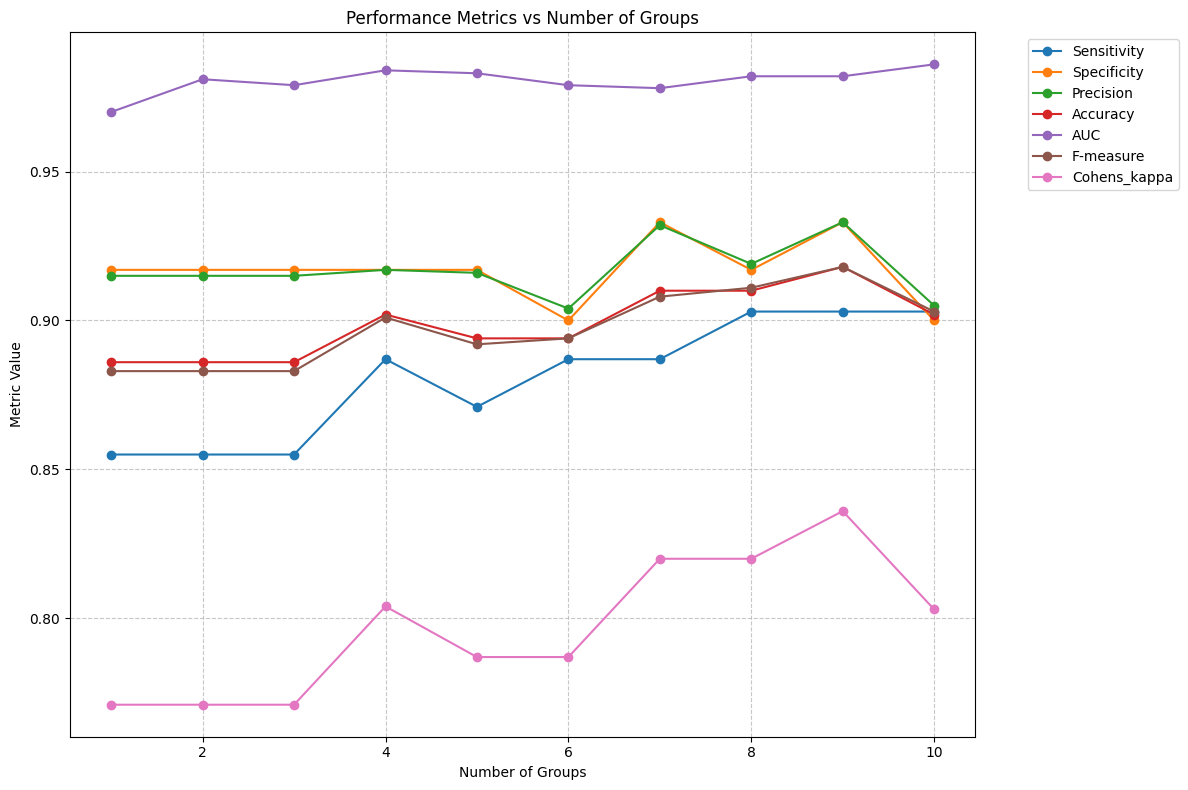

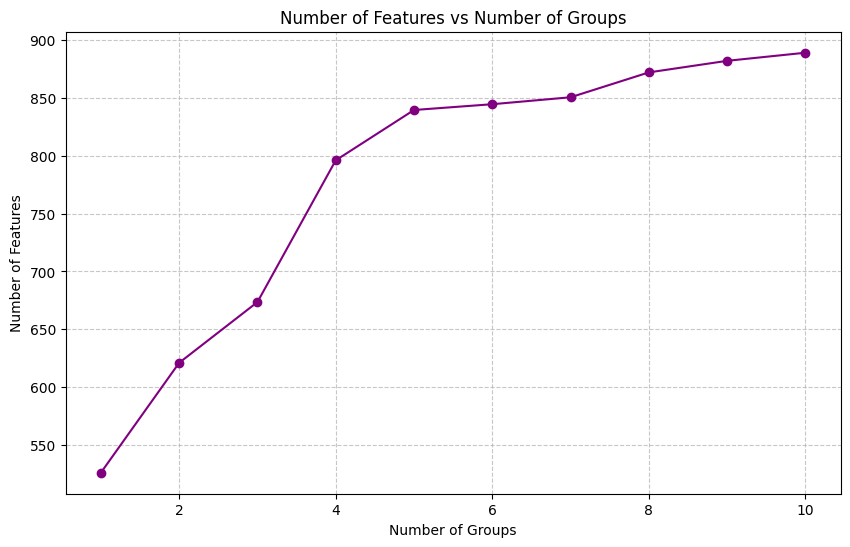

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame from the provided data
data = {
    'Groups': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Features': [526.0, 621.0, 673.5, 796.0, 839.5, 844.5, 850.5, 872.0, 882.0, 889.0],
    'Sensitivity': [0.855, 0.855, 0.855, 0.887, 0.871, 0.887, 0.887, 0.903, 0.903, 0.903],
    'Specificity': [0.917, 0.917, 0.917, 0.917, 0.917, 0.900, 0.933, 0.917, 0.933, 0.900],
    'Precision': [0.915, 0.915, 0.915, 0.917, 0.916, 0.904, 0.932, 0.919, 0.933, 0.905],
    'Accuracy': [0.886, 0.886, 0.886, 0.902, 0.894, 0.894, 0.910, 0.910, 0.918, 0.902],
    'AUC': [0.970, 0.981, 0.979, 0.984, 0.983, 0.979, 0.978, 0.982, 0.982, 0.986],
    'F-measure': [0.883, 0.883, 0.883, 0.901, 0.892, 0.894, 0.908, 0.911, 0.918, 0.903],
    'Cohens_kappa': [0.771, 0.771, 0.771, 0.804, 0.787, 0.787, 0.820, 0.820, 0.836, 0.803]
}

df = pd.DataFrame(data)

# Create the line plot
plt.figure(figsize=(12, 8))
metrics = ['Sensitivity', 'Specificity', 'Precision', 'Accuracy', 'AUC', 'F-measure', 'Cohens_kappa']

for metric in metrics:
    plt.plot(df['Groups'], df[metric], marker='o', label=metric)

plt.xlabel('Number of Groups')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs Number of Groups')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Create a second plot for Features
plt.figure(figsize=(10, 6))
plt.plot(df['Groups'], df['Features'], marker='o', color='purple')
plt.xlabel('Number of Groups')
plt.ylabel('Number of Features')
plt.title('Number of Features vs Number of Groups')
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

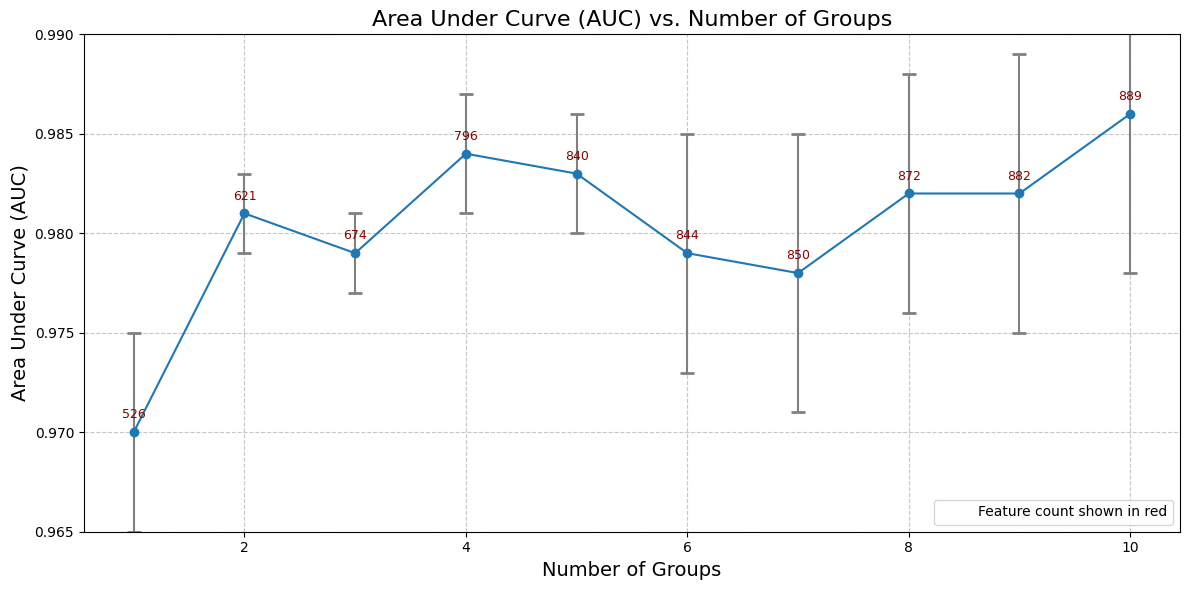

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Data
groups = range(1, 11)
auc_mean = [0.97, 0.981, 0.979, 0.984, 0.983, 0.979, 0.978, 0.982, 0.982, 0.986]
auc_std = [0.005, 0.002, 0.002, 0.003, 0.003, 0.006, 0.007, 0.006, 0.007, 0.008]
features = [526.0, 621.0, 673.5, 796.0, 839.5, 844.5, 850.5, 872.0, 882.0, 889.0]

# Create the plot
plt.figure(figsize=(12, 6))
plt.errorbar(groups, auc_mean, yerr=auc_std, fmt='-o', capsize=5, capthick=2, ecolor='gray')

# Customize the plot
plt.title('Area Under Curve (AUC) vs. Number of Groups', fontsize=16)
plt.xlabel('Number of Groups', fontsize=14)
plt.ylabel('Area Under Curve (AUC)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Add feature count annotations
for i, txt in enumerate(features):
    plt.annotate(f'{txt:.0f}', (groups[i], auc_mean[i]), textcoords="offset points", 
                 xytext=(0,10), ha='center', fontsize=9, color='darkred')

# Set y-axis limits to focus on the range of AUC values
plt.ylim(0.965, 0.99)

# Add a legend
plt.plot([], [], ' ', label='Feature count shown in red')
plt.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()

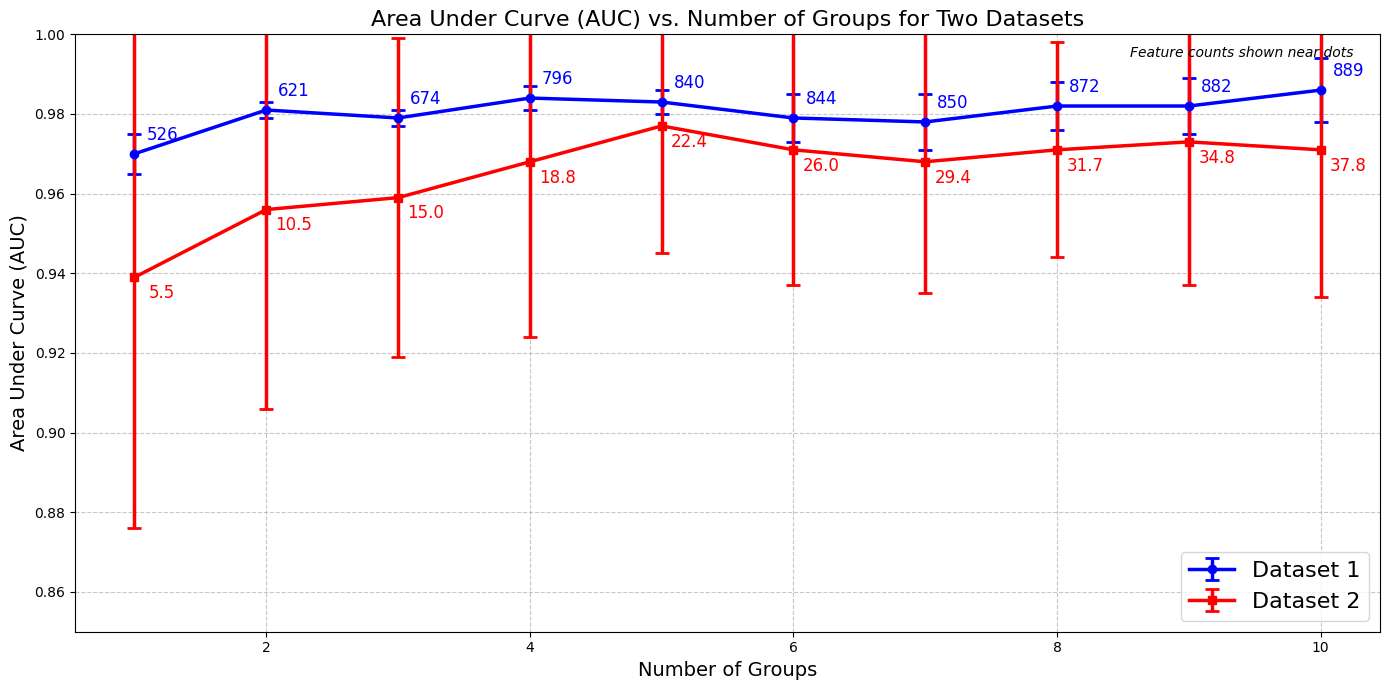

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Dataset 1
groups1 = range(1, 11)
auc_mean1 = [0.97, 0.981, 0.979, 0.984, 0.983, 0.979, 0.978, 0.982, 0.982, 0.986]
auc_std1 = [0.005, 0.002, 0.002, 0.003, 0.003, 0.006, 0.007, 0.006, 0.007, 0.008]
features1 = [526.0, 621.0, 673.5, 796.0, 839.5, 844.5, 850.5, 872.0, 882.0, 889.0]

# Data for Dataset 2
groups2 = range(1, 11)
auc_mean2 = [0.939, 0.956, 0.959, 0.968, 0.977, 0.971, 0.968, 0.971, 0.973, 0.971]
auc_std2 = [0.063, 0.050, 0.040, 0.044, 0.032, 0.034, 0.033, 0.027, 0.036, 0.037]
features2 = [5.5, 10.5, 15.0, 18.8, 22.4, 26.0, 29.4, 31.7, 34.8, 37.8]

# Create the plot
plt.figure(figsize=(14, 7))

# Plot Dataset 1
plt.errorbar(groups1, auc_mean1, yerr=auc_std1, fmt='-o', capsize=5, capthick=2, 
             color='blue', label='Dataset 1', linewidth=2.5)

# Plot Dataset 2
plt.errorbar(groups2, auc_mean2, yerr=auc_std2, fmt='-s', capsize=5, capthick=2, 
             color='red', label='Dataset 2', linewidth=2.5)

# Customize the plot
plt.title('Area Under Curve (AUC) vs. Number of Groups for Two Datasets', fontsize=16)
plt.xlabel('Number of Groups', fontsize=14)
plt.ylabel('Area Under Curve (AUC)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Add feature count annotations for Dataset 1
for i, txt in enumerate(features1):
    plt.annotate(f'{txt:.0f}', (groups1[i], auc_mean1[i]), textcoords="offset points", 
                 xytext=(20,10), ha='center', fontsize=12, color='blue')

# Add feature count annotations for Dataset 2
for i, txt in enumerate(features2):
    plt.annotate(f'{txt:.1f}', (groups2[i], auc_mean2[i]), textcoords="offset points", 
                 xytext=(20,-15), ha='center', fontsize=12, color='red')

# Set y-axis limits to focus on the range of AUC values
plt.ylim(0.85, 1)

# Add a legend
plt.legend(loc='lower right', fontsize=16)

# Add note about feature counts in the upper right corner
plt.text(0.98, 0.98, "Feature counts shown near dots", 
         horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, fontsize=10, fontstyle='italic')


# Show the plot
plt.tight_layout()
plt.show()